In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
sys.path.insert(0, '../src')
import prework as pwk
import string
from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter


import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

In [3]:
df_0 = pd.read_pickle('../data/pickles/20180117_part_one.pkl')

In [4]:
', '.join(df_0.columns)

'doc_id, path, author_code, essay_content, label, unique_lemma, avg_stc_length, total_stc, DT_pos, POS_adjv_body, POS_adjv_repeat_rate, POS_adjv_repeat_cnt, DT_archs, DT_max_dp_cnts, DT_ROOT_idx, DT_pass_cnt, DT_mark_cnt, DT_pos_join, DT_archs_join, DT_insent_pos_ngram, DT_insent_arch_ngram, DT_max_dp_cnts_std, DT_ROOT_idx_mean, DT_pass_cnt_sum, DT_mark_cnt_sum'

In [5]:
# Select all numerical features into a new dataframe
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df_0.select_dtypes(include=numerics)

In [6]:
', '.join(df_numeric.columns)

'doc_id, unique_lemma, avg_stc_length, total_stc, POS_adjv_repeat_rate, POS_adjv_repeat_cnt, DT_max_dp_cnts_std, DT_ROOT_idx_mean, DT_pass_cnt_sum, DT_mark_cnt_sum'

In [5]:
X = df_0[['unique_lemma', 'avg_stc_length', \
          'total_stc', 'POS_adjv_repeat_rate', \
          'POS_adjv_repeat_cnt', 'DT_max_dp_cnts_std', \
          'DT_ROOT_idx_mean', 'DT_pass_cnt_sum', 'DT_mark_cnt_sum']]
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Random Forest Feature Importance

In [17]:
model = ('rfclf', RandomForestClassifier())

steps = [
    model
]
random_forest_grid = {'rfclf__max_depth': [None, 2, 3],
                      'rfclf__max_features': ['sqrt', 'log2', None],
                      'rfclf__min_samples_split': [2, 3, 4],
                      'rfclf__min_samples_leaf': [1, 2, 3],
                      'rfclf__bootstrap': [True, False],
                      'rfclf__n_estimators': [200]}

pipeline = Pipeline(steps)
gridsearch = GridSearchCV(pipeline,
                         random_forest_grid,
                         n_jobs=-1,
                         cv=5,
                         verbose=1,
                         scoring='accuracy')

gridsearch.fit(X_train, y_train)
best_rf_model = gridsearch.best_estimator_
print (best_rf_model)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  9.7min finished


Pipeline(steps=[('rfclf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [5]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

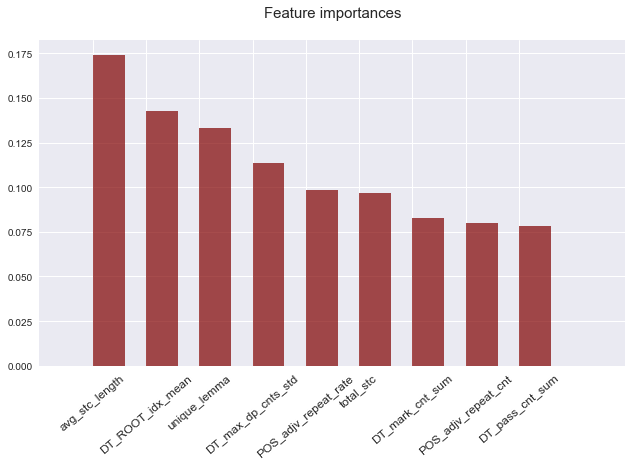

In [38]:
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
f_num = len(feature_names)
#print importances[indices]
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 6, forward=True)
#plt.figure(figsize=(12,8))
ax.set_title("Feature importances", fontsize=15)
ttl = ax.title
ttl.set_position([.5, 1.05])
ax.bar(range(f_num), importances[indices], color="maroon", align='edge', width=0.6, alpha=.7)
plt.xticks(range(f_num), feature_names, rotation=40, fontsize=12)
ax.set_xlim([-1, 10])
fig.show()

### GradientBoosting Partial Dependence

In [37]:
gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02],
                          'max_depth': [2, 4],
                          'min_samples_leaf': [1, 2, 5],
                          'max_features': [1.0, 0.5],
                          'n_estimators': [200]}

gbclf_gridsearch = GridSearchCV(GradientBoostingClassifier(), 
                              gradient_boosting_grid,
                              cv=5,
                              verbose=1,
                              n_jobs=-1,
                              scoring='accuracy')
gbclf_gridsearch.fit(X_train, y_train)
print ("best parameters:", gbclf_gridsearch.best_params_)

best_gbclf_model = gbclf_gridsearch.best_estimator_
print best_gbclf_model

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.5min finished


('best parameters:', {'max_features': 1.0, 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 2})
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=1.0, max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [6]:
gdb_clf = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=1.0, max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
gdb_clf.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=1.0, max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

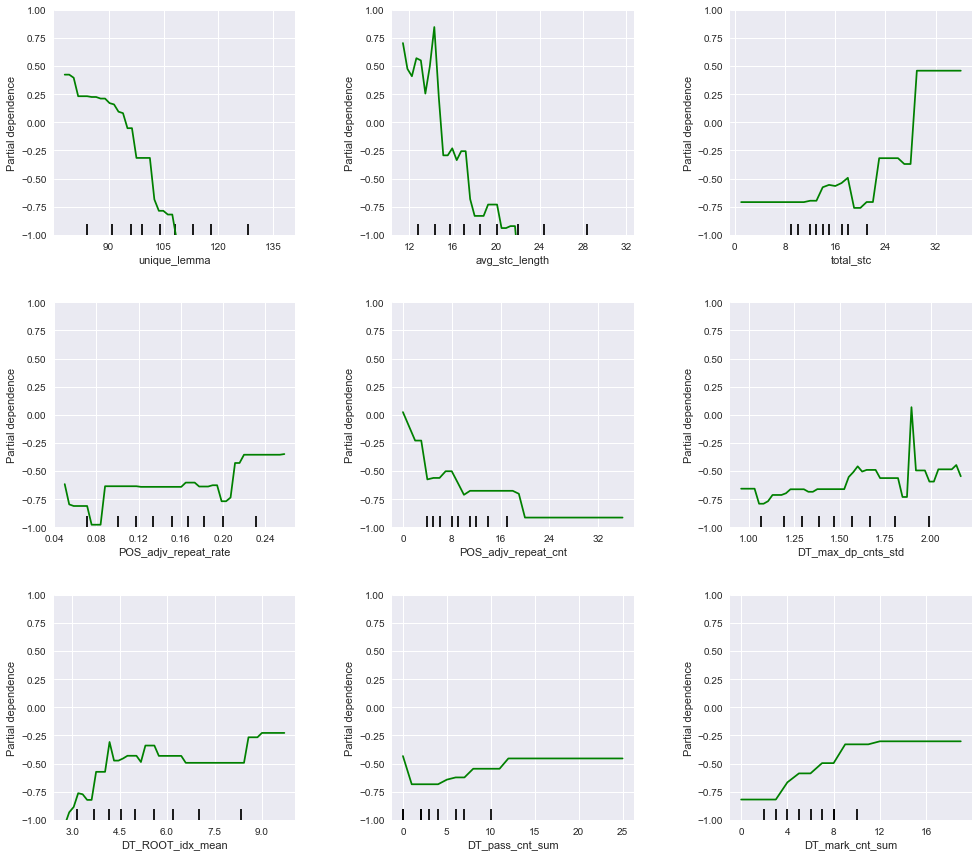

In [12]:
names = X_train.columns

features = [0,1,2,3,4,5,6,7,8]
fig, axs = plot_partial_dependence(gdb_clf, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, grid_resolution=50, label='JPN')
for x in axs:
    x.set_ylim(-1, 1)
fig.set_size_inches(15, 15, forward=True)
plt.subplots_adjust(top=0.9)

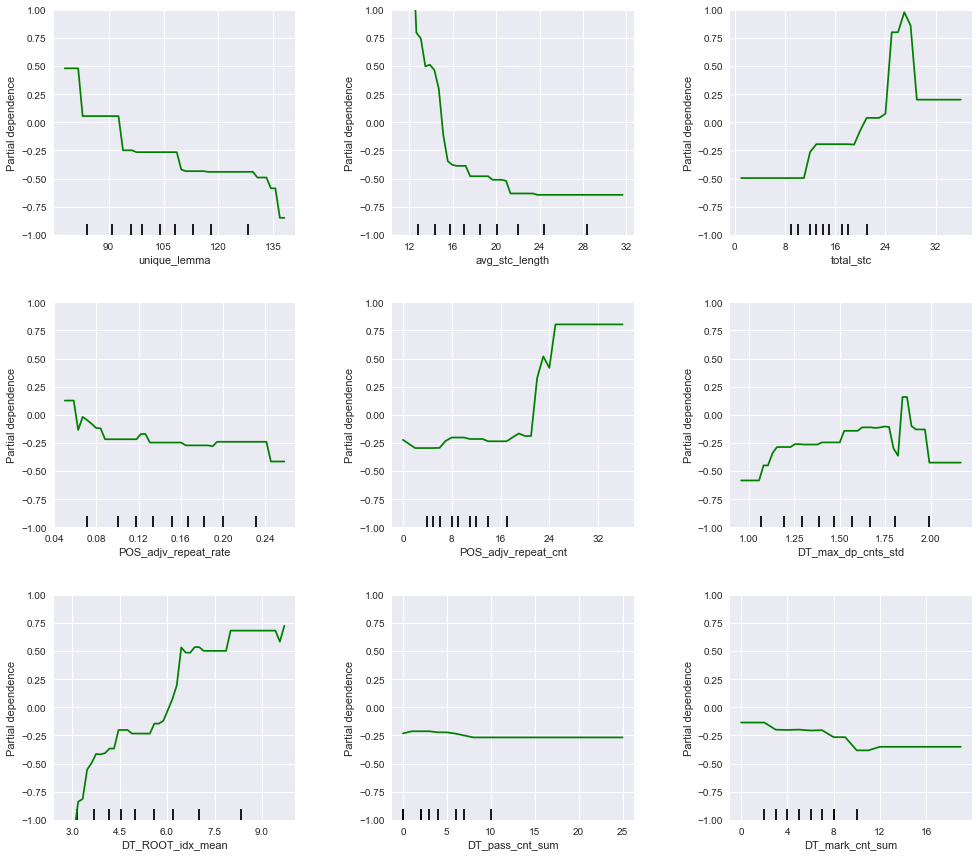

In [13]:
fig, axs = plot_partial_dependence(gdb_clf, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, grid_resolution=50, label='KOR')
for x in axs:
    x.set_ylim(-1, 1)
fig.set_size_inches(15, 15, forward=True)
plt.subplots_adjust(top=0.9)

### See how mere numeric features perform with different algorithms

In [52]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2', C=1))
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.351129889756


In [53]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.355977554772


In [54]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=1.0, max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.351245166152


### tfidf on Syntactic Features

In [83]:
X = df_0['DT_pos_join']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(3,3), max_features=800)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=5, scoring='accuracy')
print scores.mean()

0.664607324846


In [84]:
X = df_0['DT_archs_join']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(3,3), max_features=800)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=5, scoring='accuracy')
print scores.mean()

0.655624609373


In [85]:
n = 3
df_0['DT_insent_pos_ngram'] = df_0['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

X = df_0['DT_insent_pos_ngram']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(1,1), max_features=800)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=5, scoring='accuracy')
print scores.mean()

0.65240657206


In [88]:
n = 3
df_0['DT_insent_arch_ngram'] = df_0['DT_archs'].apply(lambda x: pwk.loop_body(x, n))

X = df_0['DT_insent_arch_ngram']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(1,1), max_features=800)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=5, scoring='accuracy')
print scores.mean()

0.645502590324


**Try Stack Features**

In [89]:
X = df_0[['DT_pos_join','DT_insent_pos_ngram']]
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [95]:
vectorizer1 = TfidfVectorizer(lowercase=True, ngram_range=(3,3), max_features=800).fit(X_train['DT_pos_join'])
DT_pos_join_train_dtm = vectorizer1.transform(X_train['DT_pos_join'])
DT_pos_join_test_dtm = vectorizer1.transform(X_test['DT_pos_join'])

In [96]:
vectorizer2 = TfidfVectorizer(lowercase=True, ngram_range=(1,1), max_features=800).fit(X_train['DT_insent_pos_ngram'])
DT_insent_pos_ngram_train_dtm = vectorizer2.transform(X_train['DT_insent_pos_ngram'])
DT_insent_pos_ngram_test_dtm = vectorizer2.transform(X_test['DT_insent_pos_ngram'])

In [98]:
import scipy as sp
df_all_train = sp.sparse.hstack((DT_pos_join_train_dtm, DT_insent_pos_ngram_train_dtm),format='csr')
df_all_test = sp.sparse.hstack((DT_insent_pos_ngram_test_dtm, DT_insent_pos_ngram_test_dtm),format='csr')
df_all_columns=vectorizer1.get_feature_names() + vectorizer2.get_feature_names()


In [99]:
clf = LogisticRegression()
clf.fit(df_all_train, y_train)
y_pred = clf.predict(df_all_test)
print accuracy_score(y_test, y_pred)

0.652777777778


**The accuracy does not improve much**

### Doc2vec features on classification

In [101]:
train_data, test_data = train_test_split(df_0, train_size=0.8)
col = 'essay_content'

clf = LogisticRegression()
print pwk.k_fold_doc2vec_clf(train_data, col, 2, 100, clf)

[0.81944444444444442, 0.82986111111111116, 0.80902777777777779, 0.81423611111111116, 0.83506944444444442]


In [14]:
train_data, test_data = train_test_split(df_0, train_size=0.8)

col = 'essay_content'
train_docs = pwk.tag_docs(train_data, col, literal=True)
test_docs = pwk.tag_docs(test_data, col, literal=True)
model = pwk.train_doc2vec_model(train_docs, 2, 100)
    
y_train, X_train = pwk.vec_for_learning(model, train_docs)
y_test, X_test = pwk.vec_for_learning(model, test_docs)
    
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [16]:
pwk.print_confusion_matrix(y_test, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Recall
Actual,,,,,,,,,,,
CHN,61,0,1,1,4,0,1,0,0,68,0.897059
ENS,2,58,1,1,1,0,0,6,3,72,0.805556
IDN,1,3,68,2,5,0,4,1,4,88,0.772727
JPN,1,3,1,64,8,0,0,0,2,79,0.810127
KOR,3,1,3,7,66,0,4,2,3,89,0.741573
PAK,1,0,1,1,0,76,1,1,2,83,0.915663
PHL,1,2,0,1,7,0,63,4,2,80,0.787500
SIN,0,3,2,0,0,0,2,72,0,79,0.911392
THA,3,3,2,1,3,0,4,1,65,82,0.792683
